### EEG Preprocessing with MNE  
  
MNE is a python package for working with EEG/MEG data. Documentation can be found here: [MNE Documentation](https://mne.tools/stable/documentation/index.html#)    
  
This notebook will load EEG data with MNE and begin preprocessing that data. The key steps in preprocessing resting-state EEG data are loading the data, applying initial filters to begin denoising the data, handling specific artifacts such as eye-blink artifacts, muscle movement artifacts, and cardiac artifacts.  
  
Resting-state means that patients were resting when the data was gathered. No specific tasks were performed and no specific stimuli were introduced. Because of this, epochs which center data around specific events aren't needed.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import fastparquet, pyarrow
from sklearn.preprocessing import StandardScaler

##### Loading and Splitting Data

In [2]:
df = pd.read_csv('working_data.csv')

def activity_df(activity):
    return pd.DataFrame(df[df['expert_consensus'] == activity]).reset_index().drop(columns = 'index')

other_df = activity_df('Other')
seizure_df = activity_df('Seizure')
lpd_df = activity_df('LPD')
gpd_df = activity_df('GPD')
lrda_df = activity_df('LRDA')
grda_df = activity_df('GRDA')

##### Data by Patient  
  
Of the nearly 1800 unique patients in this data, more than half of them show at least two types of brain activity. I think this is helpful information because comparisons of activity types can be done within patient before doing comparisons of activity types overall. An emphasis should be placed on this set of more than 900 patients.

In [11]:
patient_ids = np.unique(df['patient_id'])
totals = []
for i in patient_ids:
    individual_df = df[df['patient_id'] == i].copy()
    a = len(np.unique(individual_df['expert_consensus']))
    totals.append(a)

In [18]:
activity_totals = pd.DataFrame([patient_ids, totals], index = ['ID', 'Total']).transpose()
diff_activities = activity_totals[activity_totals['Total'] > 1]['ID'].copy()

In [20]:
diff_activities = diff_activities.reset_index().drop(columns = ['index'])

### Scaling with MNE  
  
Ok, so the issue that I'm having is that it seems like having the scaler transform EEGs individually is a mistake because it scales each channel according to all of that channel's data. In other words, Fp1 is standardized using the mean and standard deviation of Fp1 overall.  
  
The documentation talks about epochs, but I have resting state data? Should I treat sub EEGs as epochs and concatenate some number of sub EEGs? This would result in 50s subsets of data being stacked together and I don't think my computer could handle doing this for every sub EEG, but perhaps I could do this with enough to get reliable results. And perhaps I could do this within patient, so that difference between patients is no longer a factor.  
  
If I do that, is the overlap between sub EEGs a concern? What about differences in classification? For example, if one sub EEG is classified as Seizure and the next is classified as GPD, what do I do about that change? How do I keep track of the way each subset is classified? The overlap is again what makes this a concern.  
  
**Brainstorming:**  
  
- Concatenate whole EEGs  
- Concatenate sub EEGs  
- within patient
- within activity type  
  
**Whole EEGs:** One benefit of this I think is that overlapping sections wouldn't be counted twice. However, that may not be an issue. The difficulty I have with this is how to keep track of classification. As mentioned above, what if two overlapping sub EEGs are classified differently? How do you treat the section that overlaps? It isn't representative of two types of activity, but which one is it? Maybe I could drop these overlapping segments? Idk how much data this would result in dropping.  
  
**Sub EEGs:** Overlapping sections would be counted twice, but classification would be slightly easier to track. There's still the fact that apparently this section of data fits two different brain activity categories, but it's the whole 50s that have been classified and not that chunk on its own.  
  
**Within Patient:** There apparently can be some patient to patient differences and taking this route would eliminate that factor and because there are patients with data that represents multiple of the activity types, comparisons of activity types can be done within patient without the potential need to account for patient to patient differences.  
  
**Within Activity Type:** I don't know what the problem of doing things this way would be, but I'm also not certain there wouldn't be a problem with scaling within activity type.

## Functions to Scale, Perform PCA, and Plot Signals

In [4]:
def load_eeg(data, row):
    eeg = pd.read_parquet('train_eegs/{}.parquet'.format(data['eeg_id'][row]), engine = 'pyarrow')
    first_row = int(df['eeg_label_offset_seconds'][row] * 200)
    return eeg, first_row
    
def load_sub_eeg(eeg, first_row):
    last_row = int(first_row + 10000)
    sub_eeg = eeg[first_row:last_row]
    return sub_eeg.reset_index().drop(columns = 'index')

def scaler(eeg):
    electrodes = eeg.columns
    eeg_scaler = StandardScaler()
    eeg = eeg_scaler.fit_transform(eeg)
    eeg = pd.DataFrame(eeg, columns = electrodes)
    return eeg

### MNE

In [12]:
import mne

Loading a Sub EEG

In [20]:
grda_df.shape

(12908, 16)

In [24]:
random_index = np.random.randint(0, grda_df.shape[0], size = 1)[0]

In [25]:
random_index

10632

In [26]:
grda_sub1 = load_sub_eeg(load_eeg(grda_df, random_index)[0], load_eeg(grda_df, random_index)[1])

Each sub EEG is 50 seconds long with a sampling frequency of 200 samples per second. Sub EEGs have 19 EEG channels and one EKG (electrocardiogram) channel. MNE will store the 19 EEG channels as EEG channels and the EKG channel as an EKG channel.

In [27]:
grda_sub1.head()

,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
0,-53.270000,-76.410004,-26.209999,-18.030001,-92.570000,-88.589996,-65.900002,-0.95,-46.950001,-20.160000,-24.299999,-47.580002,-4.58,-13.590000,-13.33,-20.910000,-28.469999,-23.860001,-31.559999,-379.410004
1,-37.630001,-64.339996,-12.420000,-6.280000,-78.300003,-75.919998,-52.439999,4.03,-33.490002,-8.870000,-10.780000,-30.940001,9.45,-0.090000,-2.62,-7.590000,-14.830000,-11.070000,-31.139999,-563.479980
2,-36.340000,-62.619999,-14.060000,-8.560000,-76.849998,-72.260002,-51.310001,3.82,-33.610001,-10.810000,-13.050000,-29.120001,9.92,-3.340000,-4.80,-6.710000,-14.330000,-13.490000,-29.719999,-554.479980
3,-44.740002,-72.970001,-26.590000,-22.809999,-84.650002,-83.790001,-68.769997,-10.16,-44.540001,-23.469999,-28.410000,-36.869999,-2.17,-16.889999,-18.99,-18.709999,-29.660000,-26.549999,-38.540001,-468.559998
4,-38.310001,-67.750000,-23.320000,-14.890000,-78.459999,-77.769997,-60.500000,2.73,-37.849998,-17.930000,-21.389999,-27.160000,6.87,-9.190000,-11.68,-9.630000,-17.350000,-13.180000,-27.719999,-504.920013


The below code stores the sub EEG with MNE, identifies the EEG and EKG channels, and reads in the sampling frequency.

Under "Data," the sampling frequency of 200 Hz can be seen along with initial settings for the highpass and lowpass filters. Highpass filters allow frequencies above them through and lowpass filters allow frequencies below them through. These are defaulted to 0 Hz and 100 Hz because with a sampling frequency of 200 Hz, 0 Hz and 100 Hz are the minimum and maximum frequencies. This is a limitation of the data I have and can be seen clearly in the plot of the power spectrum below.

In [28]:
info = mne.create_info(
    grda_sub1.columns.to_list(),
    ch_types=(["eeg"]*(len(grda_sub1.columns)-1))+['ecg'],
    sfreq=200
)
info.set_montage("standard_1020")

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,22 points
Good channels,"19 EEG, 1 ECG"
Bad channels,None
EOG channels,Not available
ECG channels,EKG
Sampling frequency,200.00 Hz
Highpass,0.00 Hz
Lowpass,100.00 Hz


Converts to array for MNE. Also rescales (doesn't standardize) the data to change the unit to volts

In [29]:
raw = mne.io.RawArray(
    grda_sub1.to_numpy().T*1e-6,    # µV to V
    info
)

Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.


Plots EEG signals from 20s to 30s. Channel specified on the left. Time on the x axis.

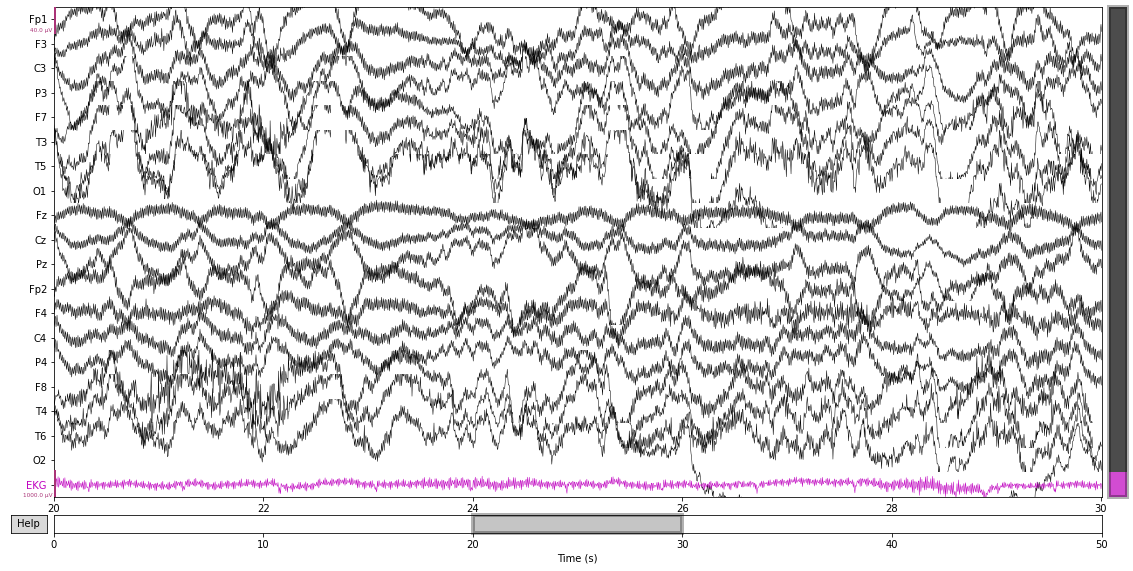

In [30]:
mne.set_config('MNE_BROWSE_RAW_SIZE','16,8')
raw.plot(start=20, duration=10)
plt.show()

### Testing Standard Scaling

In [31]:
grda_sub1 = scaler(grda_sub1)

In [33]:
info = mne.create_info(
    grda_sub1.columns.to_list(),
    ch_types=(["eeg"]*(len(grda_sub1.columns)-1))+['ecg'],
    sfreq=200
)
info.set_montage("standard_1020")

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,22 points
Good channels,"19 EEG, 1 ECG"
Bad channels,None
EOG channels,Not available
ECG channels,EKG
Sampling frequency,200.00 Hz
Highpass,0.00 Hz
Lowpass,100.00 Hz


Plots the power spectrum before any denoising. Spike at 60 Hz is important. The notch filter is meant to handle that. Then smaller spike at about 80 Hz. Unsure what this is indicative of. Also, it looks that the data spikes again at 100 Hz, but because that's the cutoff for my frequency analysis, it's difficult to see.

Effective window size : 10.240 (s)


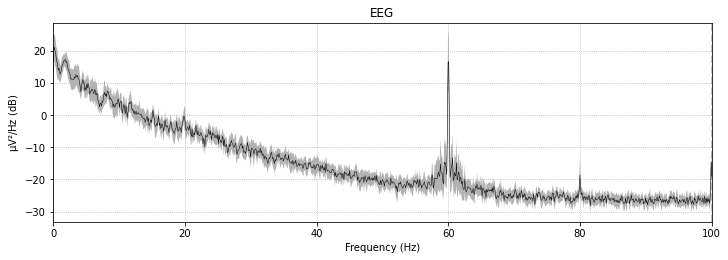

In [25]:
fig = raw.compute_psd(tmax = np.inf).plot(
    average = True, amplitude = False, picks = 'eeg', exclude = 'bads'
)

##### Note  
  
I think average referencing like this is a form of baseline correction, but I need to go back over what baseline correction is to be sure. Either way, the goal is to reduce some noise by using the global average of the EEG signals to weight each individual signal. As can be seen when comparing the plots below with the initial plots, the pattern of the signals remains the same, but the noisiness has been muted to an extent.

In [26]:
raw_avg = raw.set_eeg_reference('average')

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


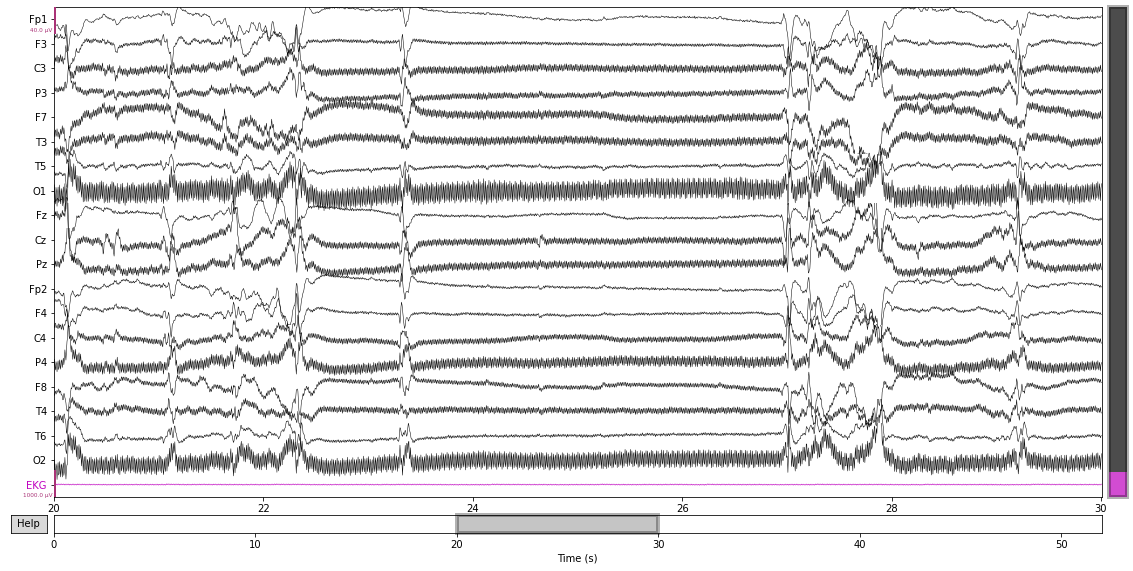

In [27]:
mne.set_config('MNE_BROWSE_RAW_SIZE','16,8')
raw_avg.plot(start=20, duration=10)
plt.show()

Filters applied to this EEG. A high pass filter (low frequency filter) of 1 Hz, a low pass filter (high frequency filter) of 70 Hz, and a notch filter at 60 Hz are applied to this EEG. These are based on recommendations found [here](https://www.learningeeg.com/montages-and-technical-components#filters).  
  
As the author of that article explains, low frequency filters are called high pass filters because they allow higher frequencies to pass through, and high frequency filters are called low pass filters because they allow lower frequencies to pass through.

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 70 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 70.00 Hz
- Upper transition bandwidth: 17.50 Hz (-6 dB cutoff frequency: 78.75 Hz)
- Filter length: 661 samples (3.305 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.0s finished


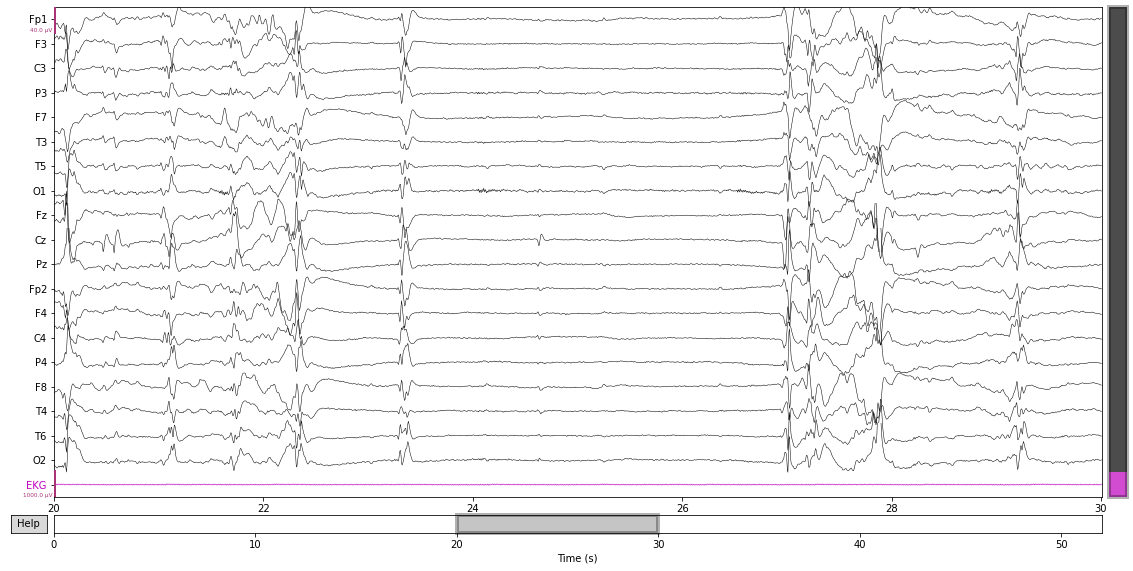

In [28]:
raw_filtered = raw_avg.copy().filter(l_freq = 1, h_freq = 70,).notch_filter(60, picks = 'eeg')
raw_filtered.plot(start = 20, duration = 10)
plt.show()

This is a plot of the power spectrum of the filtered EEG. The 80 Hz spike is still there, but the 100 Hz spike isn't. The 60 Hz spike has inverted.

Effective window size : 10.240 (s)


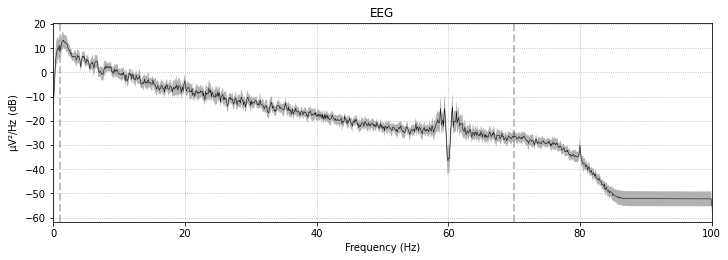

In [29]:
fig = raw_filtered.compute_psd(tmax = np.inf).plot(
    average = True, amplitude = False, picks = 'eeg', exclude = 'bads'
)

EEGs are often put in montages (sets of electrode chains which are sets of electrodes). The below code puts the filtered EEG into a [double banana bipolar montage](https://www.learningeeg.com/montages-and-technical-components#:~:text=bipolar%20montage%20II%3A%20types).  
  
This montage likely matches the montage used to generate the spectrograms provided with the data. The five groups for this montage are Left and Right Parasagittal, Left and Right Temporal (which would correspond with Lateral in this data), and Central which is either left out of the spectrograms or added to the other four groups somehow.  
  
These montages are different ways of grouping, visualizing, and analyzing EEG signals.

EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=18, n_times=10400
    Range : 0 ... 10399 =      0.000 ...    51.995 secs
Ready.
Added the following bipolar channels:
Fp1-F7, F7-T3, T3-T5, T5-O1, Fp2-F8, F8-T4, T4-T6, T6-O2, Fp1-F3, F3-C3, C3-P3, P3-O1, Fp2-F4, F4-C4, C4-P4, P4-O2, Fz-Cz, Cz-Pz


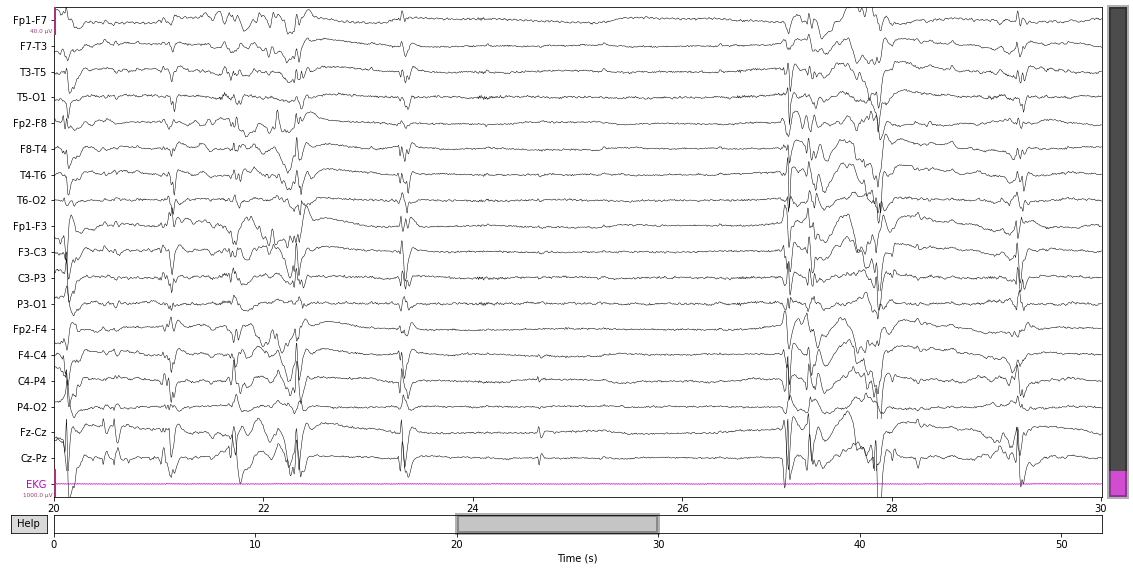

In [30]:
bipolar = [
    ['Fp1', 'F7'], ['F7', 'T3'], ['T3', 'T5'], ['T5', 'O1'],    # Left Lateral
    ['Fp2', 'F8'], ['F8', 'T4'], ['T4', 'T6'], ['T6', 'O2'],    # Right Lateral
    ['Fp1', 'F3'], ['F3', 'C3'], ['C3', 'P3'], ['P3', 'O1'],    # Left Parasagittal
    ['Fp2', 'F4'], ['F4', 'C4'], ['C4', 'P4'], ['P4', 'O2'],    # Right Parasagittal
    ['Fz', 'Cz'], ['Cz', 'Pz'],   # Central
]

anode, cathode = list(map(list, zip(*bipolar)))

raw_bip_ref = mne.set_bipolar_reference(raw_filtered, anode = anode, cathode = cathode)
raw_bip_ref.plot(start = 20, duration = 10)
plt.show()

In [31]:
raw_bip_ref

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,22 points
Good channels,"1 ECG, 18 EEG"
Bad channels,None
EOG channels,Not available
ECG channels,EKG
Sampling frequency,200.00 Hz
Highpass,1.00 Hz
Lowpass,70.00 Hz


### ICA with MNE

In [26]:
eeg1, fr1 = load_eeg(df, np.random.choice(range(df.shape[0]), size = 1)[0])
sub_eeg1 = load_sub_eeg(eeg1, fr1)

In [27]:
info = mne.create_info(
    sub_eeg1.columns.to_list(),
    ch_types=(['eeg']*(len(eeg_df.columns)-1))+['ecg'],
    sfreq=200
)
info.set_montage('standard_1020')

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,22 points
Good channels,"19 EEG, 1 ECG"
Bad channels,None
EOG channels,Not available
ECG channels,EKG
Sampling frequency,200.00 Hz
Highpass,0.00 Hz
Lowpass,100.00 Hz


In [28]:
raw = mne.io.RawArray(
    sub_eeg1.to_numpy().T*1e-6,    # µV to V
    info
)

Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.


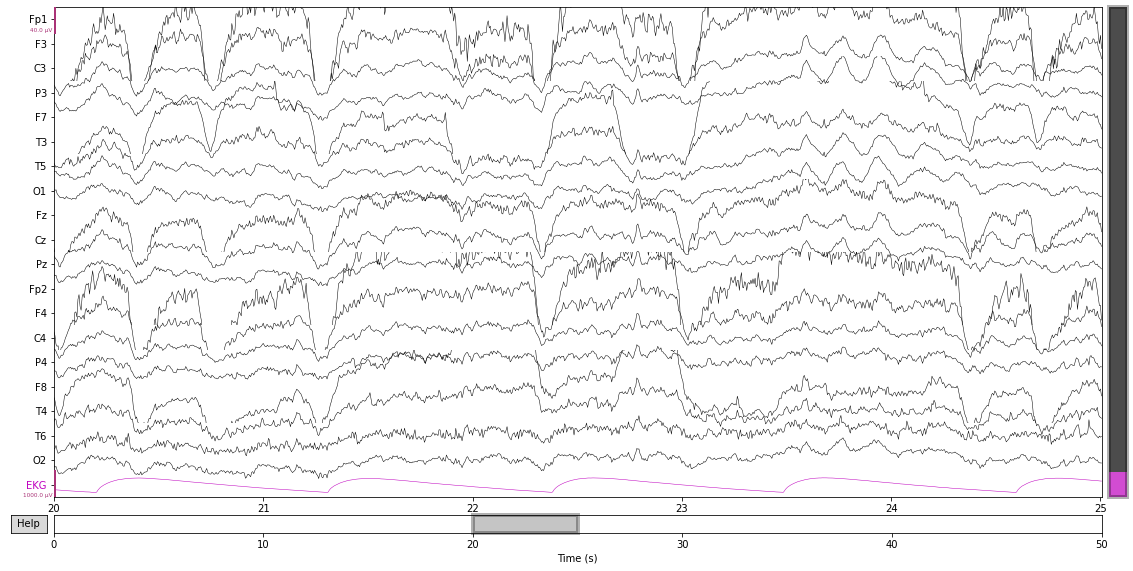

In [29]:
mne.set_config('MNE_BROWSE_RAW_SIZE','16,8')
raw.plot(start = 20, duration = 5)
plt.show()

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 70 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 70.00 Hz
- Upper transition bandwidth: 17.50 Hz (-6 dB cutoff frequency: 78.75 Hz)
- Filter length: 661 samples (3.305 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.0s finished


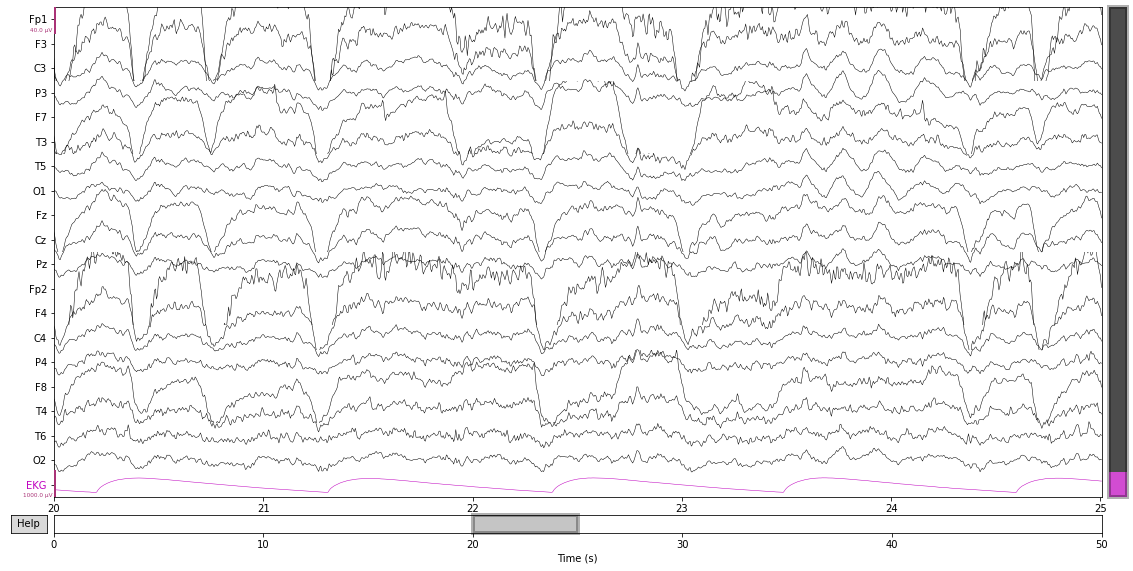

In [30]:
raw_filtered = raw.copy().filter(l_freq = 1, h_freq = 70,).notch_filter(60, picks = 'eeg')
raw_filtered.plot(start = 20, duration = 5)
plt.show()

In [31]:
from mne.preprocessing import ICA

In [32]:
method = 'fastica'

# Choose other parameters
n_components = 19
decim = 3  # we need sufficient statistics, not all time points -> saves time

random_state = 23

In [33]:
ica = ICA(n_components=n_components, method=method, random_state=random_state)
print(ica)

<ICA | no decomposition, method: fastica>


In [34]:
reject = dict(mag=5e-12, grad=4000e-13)

picks_eeg = mne.pick_types(raw_filtered.info, meg=False, eeg=True, eog=False,
                           stim=False, exclude='bads')
ica.fit(raw_filtered, picks=picks_eeg, decim=decim, reject=reject)
print(ica)

Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 19 components
Fitting ICA took 2.0s.
<ICA | raw data decomposition, method: fastica (fit in 834 iterations on 3216 samples), 19 ICA components (19 PCA components available), channel types: eeg, no sources marked for exclusion>


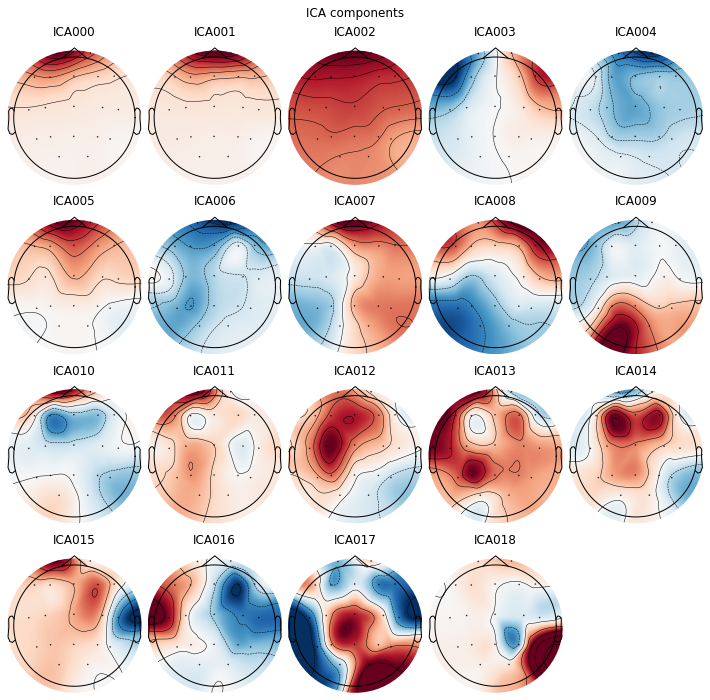

In [35]:
ica.plot_components()
plt.show()

Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.


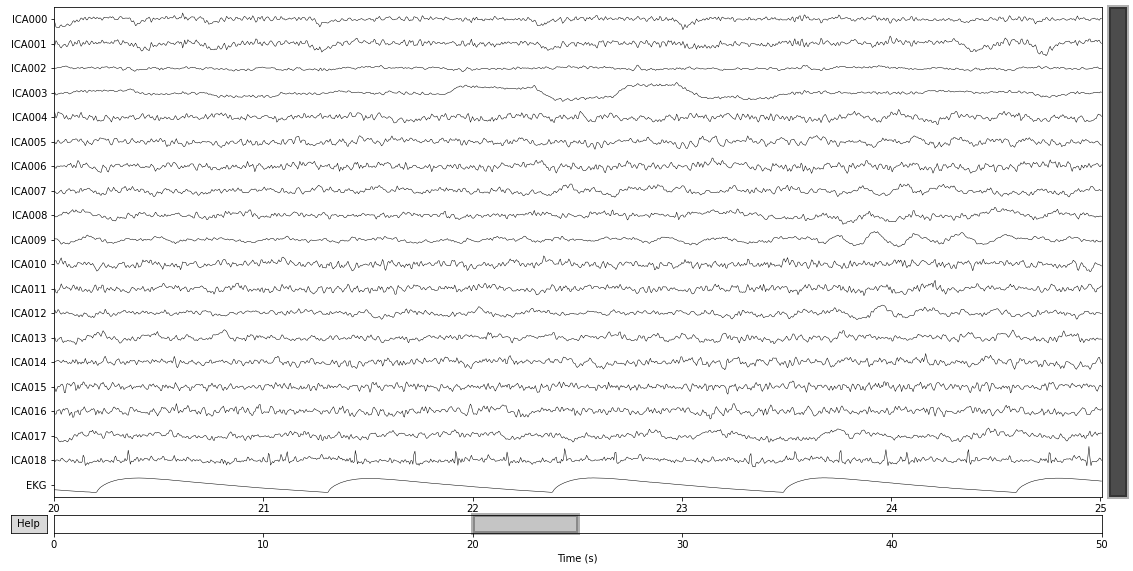

In [36]:
ica.plot_sources(raw_filtered, start = 20, stop = 25)
plt.show()

Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated


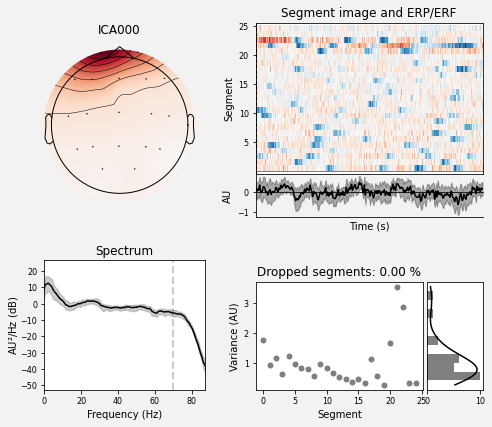

In [37]:
# first, component 0:
ica.plot_properties(raw_filtered, picks = 0)
plt.show()